##1. Word2Vec, Doc2Vec

In [ ]:
import pandas as pd
data = pd.read_csv("data_3.csv")
data["user"] = data["user"].astype("str")
data["artist"] = data["artist"].str.strip()


In [ ]:
#값을 저장할 비어있는 리스트를 만듬.
tokenized_data = []

#user별 item을 묶은 후, list로 변환
tokenized_data = data.groupby('user')['artist'].apply(list).to_list()

In [ ]:
#값을 저장할 비어있는 리스트를 만듬.
nested_data = []

# 불용어(아이템)
stopwords = []

for i in tokenized_data : #리뷰 각각에 대해서 아래작업 반복
    stopwords_removed_i = [j for j in i if not j in stopwords] # 불용어 제거
    nested_data.append(stopwords_removed_i)

len(nested_data)

1011

- 임베딩

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = nested_data,
                 vector_size = 50,
                 window = 5,
                 min_count = 5,
                 workers = 4, sg = 0)

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
import numpy as np
model.wv.vectors.shape
model.wv.vectors[1]

np.mean( (model.wv.vectors[2]-model.wv.vectors[1])**2 )

0.0011621343

In [ ]:
model.wv.key_to_index
model.wv.index_to_key

- item 간 거리 계산

In [ ]:
import numpy as np
np.sqrt(np.mean(model.wv.vectors[10]-model.wv.vectors[11])**2)

0.0030916749965399504

In [ ]:
model.wv.index_to_key[0:10]

['radiohead',
 'the beatles',
 'coldplay',
 'red hot chili peppers',
 'metallica',
 'muse',
 'pink floyd',
 'system of a down',
 'nirvana',
 'death cab for cutie']

- 유사한 단어 발견

In [ ]:
print(model.wv.most_similar("radiohead"))

[('linkin park', 0.9995406270027161), ('daft punk', 0.999530017375946), ('the velvet underground', 0.9995067119598389), ('modest mouse', 0.9994966983795166), ('tom waits', 0.9994953274726868), ('koЯn', 0.999482274055481), ('coldplay', 0.9994789958000183), ('the beatles', 0.9994731545448303), ('system of a down', 0.999472439289093), ('sufjan stevens', 0.999468982219696)]


2. Doc2Vec 활용

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_data = [TaggedDocument(words=nested_data[i], tags=[i]) for i in range(len(nested_data)) ]

In [ ]:
len(tagged_data)

1011

In [ ]:
model = Doc2Vec(
    epochs=40,
    window=5,
    vector_size=5,  #얻고자 하는 컬럼의 수, 한 문서를 몇개의 값의 좌표로 표현,
    min_count=2,  #최소 단어 빈도를 2
    dm =1)  #pv-dm: 1, pv-dbow:2

model.build_vocab(tagged_data)

In [ ]:
model.docvecs.vectors

<ipython-input-32-615016936db2>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  model.docvecs.vectors


array([[-0.10461631, -0.11958253, -0.19761507,  0.17105691,  0.07132232],
       [ 0.00526063, -0.19761255, -0.10333297, -0.19435926,  0.04021559],
       [ 0.05660622,  0.09287111, -0.08594551, -0.06291413, -0.06157575],
       ...,
       [ 0.11154249, -0.01570604, -0.00445905,  0.07836063,  0.1954169 ],
       [-0.07093506,  0.09389529, -0.16232686,  0.00580363, -0.1785196 ],
       [ 0.19743058,  0.09647214, -0.0207195 , -0.04671218,  0.10098104]],
      dtype=float32)

In [ ]:
doc_list = 'radiohead nelly'.split(' ')
doc_list

['radiohead', 'nelly']

In [ ]:
inferred_vector = model.infer_vector(doc_list)
inferred_vector

array([-0.09131812,  0.01579435,  0.03799164, -0.06941382, -0.09237896],
      dtype=float32)

- 유사한 user 발견

In [ ]:
return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn=5)
return_docs

<ipython-input-35-2e82f67434ad>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  return_docs = model.docvecs.most_similar(positive=[inferred_vector],topn=5)


[(757, 0.954725444316864),
 (941, 0.9541265964508057),
 (544, 0.9443127512931824),
 (512, 0.9392412304878235),
 (815, 0.9190414547920227)]

In [ ]:
return_docs = model.docvecs.most_similar(66,topn=3)
return_docs

<ipython-input-36-b29b1cefbd05>:1: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  return_docs = model.docvecs.most_similar(66,topn=3)


[(600, 0.935631275177002),
 (186, 0.9339579939842224),
 (214, 0.9231314659118652)]

# 2. Item2Vec
- Item2Vec: Neural Item Embedding for Collaborative Filtering


- Paper: https://arxiv.org/vc/arxiv/papers/1603/1603.04259v2.pdf


In [ ]:
import pandas as pd
import numpy as np

# 데이터 읽기
df_movies = pd.read_csv('movies.csv') # 영화 데이터
df_ratings = pd.read_csv('ratings.csv') # user의 rating 데이터

# 인코딩
movieId_to_name = pd.Series(df_movies.title.values, index = df_movies.movieId.values)
name_to_movieId = pd.Series(df_movies.movieId.values, index = df_movies.title).to_dict()

# Randomly display 5 records in the dataframe
for df in list((df_movies, df_ratings)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx,:])
    print("Randomly displaying 5 of the total "+str(len(df))+" data points")

,movieId,title,genres
9170,148881,World of Tomorrow (2015),Animation|Comedy
5650,27480,Dead or Alive 2: Tôbôsha (2000),Action|Crime|Thriller
6937,65133,Blackadder Back & Forth (1999),Comedy
2285,3032,"Omega Man, The (1971)",Action|Drama|Sci-Fi|Thriller
6618,55908,"Man from Earth, The (2007)",Drama|Sci-Fi


Randomly displaying 5 of the total 9742 data points


,userId,movieId,rating,timestamp
52128,339,4878,4.5,1460182423
87479,563,88785,3.0,1448253813
7028,47,97923,4.0,1496206766
45113,298,54503,4.0,1447584434
54414,357,6380,5.0,1348610540


Randomly displaying 5 of the total 100836 data points


- User가 rating한 영화의 개수를 히스토그램으로 시각화

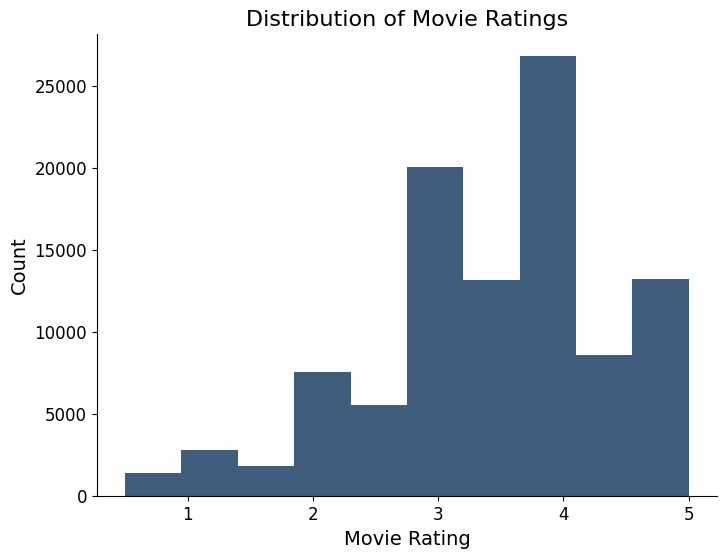

In [ ]:
import matplotlib.pyplot as plt
#import chart_studio.plotly as py
%matplotlib inline

plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.set_title("Distribution of Movie Ratings", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlabel("Movie Rating", fontsize=14)
plt.ylabel("Count", fontsize=14)

plt.hist(df_ratings['rating'], color="#3F5D7D")

plt.show()

##  train set, test set 만들기


In [ ]:
from sklearn.model_selection import train_test_split

df_ratings_train, df_ratings_test= train_test_split(df_ratings,
                                                    stratify=df_ratings['userId'],
                                                    random_state = 15688,
                                                    test_size=0.30)


print("Number of training data: "+str(len(df_ratings_train)))
print("Number of test data: "+str(len(df_ratings_test)))

Number of training data: 70585
Number of test data: 30251


In [ ]:
def rating_splitter(df):

    df['liked'] = np.where(df['rating']>=4, 1, 0) # df['rating']이 4이상이면 1 아니면 0
    df['movieId'] = df['movieId'].astype('str')
    gp_user_like = df.groupby(['liked', 'userId']) # liked와 user_id로 그룹화
    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups])

In [ ]:
pd.options.mode.chained_assignment = None
splitted_movies = rating_splitter(df_ratings_train)

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

import gensim

In [ ]:
len(splitted_movies)

1214

In [ ]:
new_splitted_movies = splitted_movies[:1000]

Shuufle train data

In [ ]:
import random

for movie_list in new_splitted_movies:
    random.shuffle(movie_list)

- w2v: Skip-gram을 사용한 Word2Vec 모델

In [ ]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model = Word2Vec(sentences = new_splitted_movies, # We will supply the pre-processed list of moive lists to this parameter
                 epochs = 5, # epoch
                 min_count = 10, # a movie has to appear more than 10 times to be keeped
                 vector_size = 200, # size of the hidden layer
                 workers = 4, # specify the number of threads to be used for training
                 sg = 1, # Defines the training algorithm. We will use skip-gram so 1 is chosen.
                 hs = 0, # Set to 0, as we are applying negative sampling.
                 negative = 5, # If > 0, negative sampling will be used. We will use a value of 5.
                 window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
model.save('item2vec_20241213')
del model

Time passed: 0:00:31.765398


In [ ]:
from gensim.models import Word2Vec
import datetime
start = datetime.datetime.now()

model_w2v_sg = Word2Vec(sentences = splitted_movies,
                        epochs = 10, # epoch
                        min_count = 5, # a movie has to appear more than 5 times to be keeped
                        vector_size = 300, # size of the hidden layer
                        workers = 4, # specify the number of threads to be used for training
                        sg = 1,
                        hs = 0,
                        negative = 5,
                        window = 9999999)

print("Time passed: " + str(datetime.datetime.now()-start))
model_w2v_sg.save('item2vec_word2vecSg_20241213')
del model_w2v_sg

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')

from gensim.models import Word2Vec
model = Word2Vec.load('item2vec_20241213')
word_vectors = model.wv


# 3. Transformer

In [ ]:
import os
import zipfile
import urllib.request
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import requests
import re

# Define download path (adjust as needed)
download_path = ""

# MovieLens dataset URL
dataset = "ml-latest-small.zip"

# Check if the unzipped dataset folder already exists
unzipped_folder = "ml-latest-small"
if not os.path.exists(unzipped_folder):
    # Extract the ZIP file if the folder doesn't exist
    with zipfile.ZipFile(dataset, 'r') as zip_ref:
        zip_ref.extractall(download_path)
else:
    print("Unzipped dataset folder already exists, using existing files.")

# Load data from the unzipped folder
ratings = pd.read_csv(os.path.join(unzipped_folder, "ratings.csv"))
movies = pd.read_csv(os.path.join(unzipped_folder, "movies.csv"))
tags = pd.read_csv(os.path.join(unzipped_folder, "tags.csv"))
links = pd.read_csv(os.path.join(unzipped_folder, "links.csv"))

# Combine user & movie data
data = pd.merge(ratings, movies, on="movieId")

# Define function to prepare user data
def prepare_user_data(user_id):
    user_data = data[data["userId"] == user_id]

    # Get movie IDs instead of titles
    user_movies = user_data["movieId"].to_list()[:5]
    user_genres = user_data["genres"].iloc[0].split("|") if not user_data.empty else []
    user_tags = tags[tags["userId"] == user_id]["tag"].to_list() if user_id in tags["userId"].unique() else []
    return user_movies, user_genres, user_tags

# Example: Get data for User ID 1
user_id = 2
user_movies, user_genres, user_tags = prepare_user_data(user_id)

# Initialize T5Tokenizer with model_max_length
tokenizer = T5Tokenizer.from_pretrained("t5-base", model_max_length=1024)

# Load T5 model
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# Access external movie information using links.csv and TMDB API
def get_movie_info(movie_id):
    try:
        # Check if movie ID exists in links DataFrame
        if not links.query(f"movieId == {movie_id}").empty:
            tmdb_id = links[links["movieId"] == movie_id]["tmdbId"].iloc[0]
            url = f"https://api.themoviedb.org/3/movie/{tmdb_id}?api_key=d5fea57cced3ac269b1f838683f2d574"  # Replace with your TMDB API key
            response = requests.get(url)
            data = response.json()
            title = data.get("title", "Title not found")
            return title
        else:
            print(f"Movie ID {movie_id} not found in links DataFrame.")
            return "Title not found"
    except IndexError:
        print(f"Missing TMDB ID for movie ID {movie_id}.")
        return "Title not found"
    except requests.exceptions.RequestException as e:
        print(f"Error fetching movie information from TMDB API: {e}")
        return "Title not found"

# Create T5 prompt with user features and movie information
prompt_user_movies = f"A user has watched {', '.join([str(movie_id) for movie_id in user_movies])}."
prompt_genres_tags = f"They seem to enjoy {', '.join(user_genres)} genres and movies with tags like {', '.join(user_tags)}."

# Combine the prompts with a delimiter
prompt = f"{prompt_user_movies} {prompt_genres_tags}"

# Use the "recommend" keyword in the prompt
prompt += " Recommend some movies they might enjoy."

# Encode prompt for model
user_input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Generate movie recommendations
output = model.generate(
    user_input_ids, max_length=256, num_beams=5, num_return_sequences=3
)

# Decode and print recommendations
top_recommendations = [tokenizer.decode(seq, skip_special_tokens=True) for seq in output]

# Extract IDs using regular expression
pattern = r"\d+"
recommended_ids_set = set()

for i, row in enumerate(top_recommendations):
    matches = re.findall(pattern, row)
    recommended_ids_set.update(matches)
    # print(f"Recommendation {i+1}: {row}")

# Convert the set to a list if needed
recommended_ids = list(recommended_ids_set)

# Get movie titles from retrieved IDs
recommended_titles = [get_movie_info(int(recommended_id)) for recommended_id in recommended_ids]

# Print recommendations with titles
print(f"\nTop Recommendations with Titles for the user {user_id}:")
for i, title in enumerate(recommended_titles):
    print(f"{i + 1}. {title}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Top Recommendations with Titles for the user 2:
1. Good Will Hunting
2. Kill Bill: Vol. 1
3. Gladiator
4. The Shawshank Redemption
5. Tommy Boy


#4. 실습

In [ ]:
ratings = pd.read_csv("ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
pd.to_datetime(ratings.timestamp, unit="s")

,timestamp
0,2000-07-30 18:45:03
1,2000-07-30 18:20:47
2,2000-07-30 18:37:04
3,2000-07-30 19:03:35
4,2000-07-30 18:48:51
...,...
100831,2017-05-03 21:53:22
100832,2017-05-03 22:21:31
100833,2017-05-08 19:50:47
100834,2017-05-03 21:19:12


In [ ]:
# 평점 2-4점 user들에 대한 w2v, d2v 적용
# 2016, 2017의 w2v, d2v 적용

#5. DNN Embedding 사용

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies = pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:15]
g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:15]

In [ ]:
top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

<ipython-input-107-ac7e07bed734>:3: FutureWarning: The provided callable <function sum at 0x7e1dc1424670> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)


movieId,1,50,110,260,296,318,356,480,527,589,593,1196,2571,2858,2959
userId,,,,,,,,,,,,,,,
68,2.5,3.0,2.5,5.0,2.0,3.0,3.5,3.5,4.0,3.5,3.5,5.0,4.5,5.0,2.5
182,4.0,4.5,3.5,3.5,5.0,4.5,5.0,3.5,4.0,2.0,4.5,3.0,5.0,5.0,5.0
249,4.0,4.0,5.0,5.0,4.0,4.5,4.5,4.0,4.5,4.0,4.0,5.0,5.0,4.5,5.0
274,4.0,4.0,4.5,3.0,5.0,4.5,4.5,3.5,4.0,4.5,4.0,4.5,4.0,5.0,5.0
288,4.5,NaN,5.0,5.0,5.0,5.0,5.0,2.0,5.0,4.0,5.0,4.5,3.0,NaN,3.5
307,4.0,4.5,3.5,3.5,4.5,4.5,4.0,3.5,4.5,2.5,4.5,3.0,3.5,4.0,4.0
380,5.0,4.0,4.0,5.0,5.0,3.0,5.0,5.0,NaN,5.0,5.0,5.0,4.5,NaN,4.0
387,NaN,4.5,3.5,4.5,5.0,3.5,4.0,3.0,NaN,3.5,4.0,4.5,4.0,4.5,4.5
414,4.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,5.0,5.0


In [ ]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['user'].nunique()
ratings

,userId,movieId,rating,timestamp,user
0,1,1,4.0,964982703,0
1,1,3,4.0,964981247,0
2,1,6,4.0,964982224,0
3,1,47,5.0,964983815,0
4,1,50,5.0,964982931,0
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609
100832,610,168248,5.0,1493850091,609
100833,610,168250,5.0,1494273047,609
100834,610,168252,5.0,1493846352,609


In [ ]:
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movie'].nunique()
ratings['rating'] = ratings['rating'].values.astype(np.float32)
ratings.head()

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,2
2,1,6,4.0,964982224,0,5
3,1,47,5.0,964983815,0,43
4,1,50,5.0,964982931,0,46


In [ ]:
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9724, 0.5, 5.0)

In [ ]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape
((90003, 2), (10001, 2), (90003,), (10001,))

((90003, 2), (10001, 2), (90003,), (10001,))

In [ ]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding, Input, Reshape, Dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)

    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)

    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [ ]:
model = RecommenderV1(n_users, n_movies, n_factors)
model.summary()
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=2,
                    verbose=1, validation_data=(X_test_array, y_test))

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_15            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_18 (Embedding)  │ (None, 1, 50)          │         30,500 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_19 (Embedding)  │ (None, 1, 50)          │        486,200 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_18 (Reshape)      │ (None, 50)             │              0 │ embedding_18[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_19 (Reshape)      │ (None, 50)             │              0 │ embedding_19[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_5 (Dot)               │ (None, 1)              │              0 │ reshape_18[0][0],      │
│                           │                        │                │ reshape_19[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 516,700 (1.97 MB)

 Trainable params: 516,700 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 12.2287 - val_loss: 3.2010
Epoch 2/2
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 2.3351 - val_loss: 1.6176


In [ ]:
model.predict( X_test_array )

316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[2.4465265],
       [3.498873 ],
       [2.9586039],
       ...,
       [3.3351278],
       [2.4027658],
       [3.3355606]], dtype=float32)

In [ ]:
y_test

array([4.5, 3. , 3. , ..., 4.5, 3. , 2. ], dtype=float32)